In [6]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skmisc.loess import loess
from sklearn.metrics import log_loss, brier_score_loss

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

#from sklearn import metrics
import statsmodels.api as sm

sns.set_style("ticks")
custom_palette = ["red", "green", "orange", "blue"]
sns.set_palette(custom_palette)
grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'}    

#EXPERIMENT_NAME = 'big_test_mmd_tuning'
#EXPERIMENT_NAME = 'big_test_erm_recalibration'
#EXPERIMENT_NAME = 'big_test_regularized_tuning'
EXPERIMENT_NAME = 'big_test_erm_tuning'

num_configs=1

args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/pooled_cohorts/cohort_extraction/all_cohorts_0.2test.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts'
       }

output_path = '/labs/shahlab/projects/agataf/fairness_utility/eval/plots'
experiment_plot_path=os.path.join(output_path, EXPERIMENT_NAME)
aggregate_path = os.path.join(args['base_path'], 'experiments', 
                              EXPERIMENT_NAME, 'performance',
                              'all')

os.makedirs(experiment_plot_path, exist_ok=True)
os.makedirs(aggregate_path, exist_ok=True)

preds = pd.read_csv(os.path.join(aggregate_path, 'predictions.csv'))
preds_eval = preds.query("phase=='eval'")
preds_test = preds.query("phase=='test'")

In [7]:
aggregate_path = os.path.join(args['base_path'], 'experiments', 'big_test_erm_tuning', 'performance', 'all')
test_calibs = pd.read_csv(os.path.join(aggregate_path, 'predictions_test_recalibrated.csv'))

test_calibs = (test_calibs
               .drop('pred_probs', axis=1)
               .rename(columns={'calibration_density': 'pred_probs'})
               .filter(preds.columns)
               .assign(calibrated=True)
              )

preds_test = (preds_test
         .assign(calibrated=False)
         #.query('phase=="test"')
         .append(test_calibs)
        )

preds_test

,phase,outputs,pred_probs,labels,person_id,weights,group,treat,ldlc,relative_risk,fold_id,config_id,lambda_reg,calibrated
1905,test,-0.866176,0.018488,0,11,1.068377,2,0,155.087,1.000000,1,0,0,False
1907,test,-1.272125,0.020800,0,27,1.068377,2,0,125.494,1.000000,1,0,0,False
1908,test,-1.263910,0.027816,0,32,1.068377,2,0,146.310,1.000000,1,0,0,False
1909,test,-0.778822,0.016303,0,42,1.068377,2,0,172.901,1.000000,1,0,0,False
1911,test,-1.263901,0.018589,0,51,1.068377,2,0,134.000,1.000000,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23425,test,-1.794496,0.199440,1,22880,1.004032,4,1,98.000,0.803684,10,0,0,True
23426,test,-1.002330,0.525367,1,22884,1.050965,4,2,139.000,0.596522,10,0,0,True
23427,test,-1.926188,0.388215,1,22931,1.004032,4,2,110.000,0.664414,10,0,0,True
23428,test,-1.358585,0.406652,1,22934,1.000000,4,2,136.000,0.603211,10,0,0,True


## use calibration evaluator, aggregate across folds

In [4]:
def calib_performance(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )
    
    results = pd.DataFrame.from_dict({'metric': ['brier', 'logloss'],
                 'value': [brier, logloss],
                 })

    return results


def get_calib_probs(model, x, transform=None):
    
    if transform=='log':
        model_input = np.log(x)
    else:
        model_input = x
        
    calibration_density = model.predict_proba(model_input.reshape(-1, 1))[:, -1]
                    
    df = pd.DataFrame({'pred_probs': x,
                       'model_input': model_input,
                       'calibration_density': calibration_density})  
    return df
    
def get_calib_model(preds_test, transform=None):
    
    evaluator = CalibrationEvaluator()
    _, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                     preds_test.pred_probs,
                                                     preds_test.weights,
                                                     transform = transform)

    return model

In [4]:
def calc_score(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )
    
    

    return brier, logloss

def calc_calibration(preds, num_configs, transform=None):
    calib_dfs = []
    fits=[]
    for config_id in range(num_configs):
        for group in range(1,5):
            preds_test_grp = preds.query("(phase=='test') \
                    & (config_id==@config_id) \
                    & (group==@group)")
            for fold_id in range(1,11):
                preds_test = preds_test_grp.query("fold_id==@fold_id")
                lambda_reg = preds_test.lambda_reg.unique()[0]
                evaluator = CalibrationEvaluator()
                kwargs = {'fold_id': fold_id,
                          'config_id': config_id,
                          'group': group,
                          'lambda_reg': str(round(lambda_reg, 3))
                         }

                df, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                                 preds_test.pred_probs,
                                                                 preds_test.weights,
                                                                 transform = transform)
                
                score, logloss = calc_score(model, 
                                            x = preds_test.pred_probs,
                                            y = preds_test.labels, 
                                            sample_weight = preds_test.weights,
                                            transform = transform)
                fits.append({'score': score,
                             'logloss': logloss,
                             })
                fits.append(kwargs)
                
                # (TODO): extend predict_utils metrics.py to do predict_proba with the correct transformation
                
                df_synth = pd.DataFrame({"pred_probs": np.linspace(1e-15,preds_test_grp.pred_probs.max(), 30)})   
                calib_synth = get_calib_predictions(df_synth, transform, model)
                df_synth = df_synth.assign(calibration_density = calib_synth,
                                           **kwargs)                   
                calib_dfs.append(df_synth)
                

    calibrations_df = (pd
                       .concat(calib_dfs)
                       .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                               is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                              )
                      )
    
    fits_df = pd.DataFrame(fits).assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                                        is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                                       )
    
    return calibrations_df, fits_df

In [8]:
def get_calib_predictions(df, transform, model):
    
    if transform=='log':
        df = df.assign(model_input=lambda x: np.log(x.pred_probs))
        calibration_density = model.predict_proba(df.model_input.values.reshape(-1, 1))
    else:
        calibration_density = model.predict_proba(df.pred_probs.values.reshape(-1, 1))
                    
    if len(calibration_density.shape) > 1:
        calibration_density = calibration_density[:, -1]   
    return calibration_density

## use log transform

In [14]:
df_to_calibrate = preds_test#.assign(pred_probs = lambda x: test_calibs.calibration_density)

calibs_final=[]
#for config_id in range(num_configs):
for calib in [True, False]:
    for group in [1,2,3,4]:
        max_pred_prob = df_to_calibrate.query("(group==@group) & (calibrated==@calib)").pred_probs.values.max()
        for fold_id in range(1,11): 
            for iter in range(1000):
                group_df = (df_to_calibrate
                            .query("(group==@group) & (fold_id==@fold_id) & (calibrated==@calib)")
                            .sample(frac=1, replace=True)
                           )
                #lambda_reg = group_df.lambda_reg.unique()[0]

                model = get_calib_model(group_df, transform='log')
                thr_calib = (get_calib_probs(model, 
                                             [0.075, 0.2],
                                             'log')
                             .assign(group = group,
                                     calibrated = calib
                                    #lambda_reg = str(round(lambda_reg, 3))
                                    )
                            )
                calibs_final.append(thr_calib)
            print(calib, group, fold_id)
calibs_final = pd.concat(calibs_final)

True 1 1
True 1 2
True 1 3
True 1 4
True 1 5
True 1 6
True 1 7
True 1 8
True 1 9
True 1 10
True 2 1
True 2 2
True 2 3
True 2 4
True 2 5
True 2 6
True 2 7
True 2 8
True 2 9
True 2 10
True 3 1
True 3 2
True 3 3
True 3 4
True 3 5
True 3 6
True 3 7
True 3 8
True 3 9
True 3 10
True 4 1
True 4 2
True 4 3
True 4 4
True 4 5
True 4 6
True 4 7
True 4 8
True 4 9
True 4 10
False 1 1
False 1 2
False 1 3
False 1 4
False 1 5
False 1 6
False 1 7
False 1 8
False 1 9
False 1 10
False 2 1
False 2 2
False 2 3
False 2 4
False 2 5
False 2 6
False 2 7
False 2 8
False 2 9
False 2 10
False 3 1
False 3 2
False 3 3
False 3 4
False 3 5
False 3 6
False 3 7
False 3 8
False 3 9
False 3 10
False 4 1
False 4 2
False 4 3
False 4 4
False 4 5
False 4 6
False 4 7
False 4 8
False 4 9
False 4 10


In [15]:
a = calibs_final.assign(group = lambda x: x.group.map(grp_label_dict))

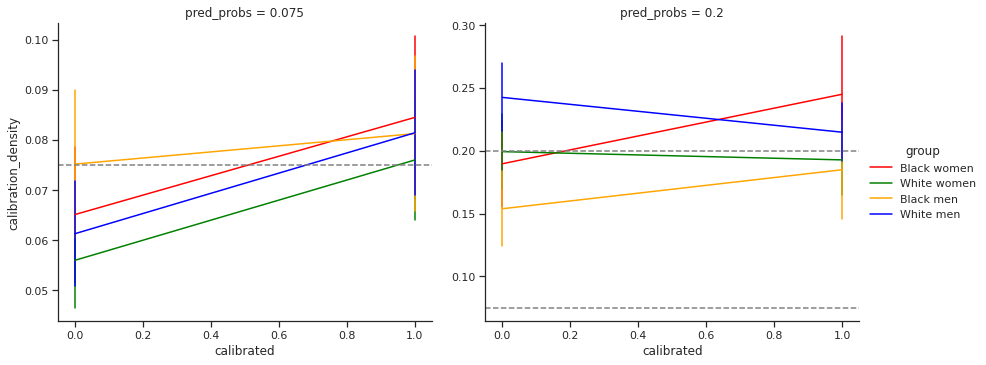

In [17]:
    output_path = os.path.join(experiment_plot_path, 'real_thresholds.png')
    g = sns.relplot(data = a,
                    x = 'calibrated',
                    y = 'calibration_density',
#                     row = 'group',
                     col = 'pred_probs',
#                     kind = 'line',
                   hue = 'group',
                    facet_kws = {'sharey': False, 'sharex': False},# 'margin_titles': True},
                    legend = True,
                    ci='sd',
                    kind="line",
                    err_style='bars',
                    aspect = 1.2)
    axes = g.axes.flatten()
    axes[0].axhline(y = 0.075, linestyle = '--', color = 'grey')
    axes[1].axhline(y = 0.075, linestyle = '--', color = 'grey')
    axes[1].axhline(y = 0.2, linestyle = '--', color = 'grey')

        
    if output_path is not None:
        g.savefig(output_path)